In [62]:
import os
import pickle
import numpy as np
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomContrast, RandomTranslation, Input, Dense, Flatten
from sklearn.model_selection import train_test_split

In [63]:
class ResNetModel():
    def __init__(self):
        self.data_augmentation = Sequential([
            RandomBrightness(factor=0.2),
            RandomContrast(factor=0.2),
            RandomFlip("horizontal"),
            RandomTranslation(height_factor=0.1, width_factor=0.1),
            RandomRotation(factor=0.1)
        ])
        
    def load_data(self, data_path: str, input_size:tuple = (224, 224)):
        image_list = []
        class_list = []
        self.input_size = input_size
        faceCascade = cv2.CascadeClassifier('Cascades/haarcascade_frontalface_default.xml')
        for label in os.listdir(data_path):
            if len(os.listdir(os.path.join(data_path, label))) < 5:
                continue
            for j, filename in enumerate(os.listdir(os.path.join(data_path, label))):
                if j >= 10:
                    break
                filename = os.path.join(data_path, label, filename)
                image = load_img(filename)
                # image = load_img(filename, color_mode = color_mode)
                # if color_mode != "grayscale":
                #     gray = np.array(rgb_to_grayscale(image))
                # else:
                #     gray = np.array(image.copy())
                image = np.array(image)
                faces = faceCascade.detectMultiScale(
                    image,     
                    scaleFactor=1.2,
                    minNeighbors=5,     
                    minSize=(20, 20)
                )
                for (x,y,w,h) in faces:
                    if w == 0 or h == 0:
                        continue
                    image_roi = image[y:y+h, x:x+w]
                    image_roi = img_to_array(image_roi)
                    image_roi = resize(image_roi, input_size)
                    
                    image_list.append(image_roi)
                    class_list.append(label)
                    print(f"Index {j}. {filename}")
                    
        os.system("cls")
        encoder = OneHotEncoder(sparse_output=False)
        class_list = encoder.fit_transform(np.array(class_list).reshape(-1, 1))
        
        image_list = np.asarray(image_list)
        self.label_names = encoder.categories_[0]
        
        X_train, X_temp, y_train, y_temp = train_test_split(image_list, class_list, test_size=0.3)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        print(f"Train dataset len: {X_train.shape[0]}")
        print(f"Val dataset len: {X_val.shape[0]}")
        print(f"Test dataset len: {X_test.shape[0]}")
        print(f"Sample image shape: {X_train[0].shape}")
                    
    def save(self, save_path):
        with open(save_path + ".pickle", "wb") as file:
            pickle.dump(self, file)
        return
        
    def fit(self, model_name: str, augmentation=True, save_path=None, batch_size=64, epochs=10):
        inputs = Input(shape=self.X_train[0].shape)
        layer = self.data_augmentation(inputs) if augmentation else inputs
        
        base_model = VGGFace(model=model_name, include_top=False, input_shape=self.X_train[0].shape, pooling="avg")
        base_model.trainable = False
        
        layer = base_model(layer)
        
        layer = Flatten(name="Flatten")(layer)
        out = Dense(len(self.label_names), activation="softmax")(layer)
        
        model = Model(inputs, out)
        model.compile(optimizer="adam", metrics=["accuracy"], loss="categorical_crossentropy")
        
        print(model.summary())
        
        self.history = model.fit(
            self.X_train, self.y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(self.X_val, self.y_val),
            callbacks=[EarlyStopping(monitor="val_loss", patience=3)]
        )
        
        self.model = model
        if save_path is not None:
            self.save(save_path)
        
        loss, accuracy = model.evaluate(self.X_test, self.y_test)
        print(f"Test accuracy:{(accuracy * 100):2f}")
        print(f"Test loss:{loss:2f}")
        return model

            
    def predict(self, predict_image):
        predict_image = img_to_array(predict_image)
        predict_image = resize(predict_image, self.input_size)
        predict_image = np.expand_dims(predict_image, axis=0)
        predict_label = self.model.predict(predict_image)
        return self.label_names[np.argmax(predict_label)], np.max(predict_label)

In [71]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,480)

faceCascade = cv2.CascadeClassifier('Cascades/haarcascade_frontalface_default.xml')
faceRecognition = pickle.load(open("model_v1_resnet.pickle", "rb"))
while(True):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    faces = faceCascade.detectMultiScale(
        frame,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20)
    )
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
        roi_color = frame[y:y+h, x:x+w]
        roi_color = cv2.flip(roi_color, 1)
        label, conf = faceRecognition.predict(roi_color)
        label = label[:12] + "..." if len(label) > 10 else label
        # print(label, conf)
        text = "{label} : {conf:.3f}".format(label = label, conf = conf)
        
        cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    cv2.imshow('video',frame)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27: # press 'ESC' to quit
        break
    os.system('cls')
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 104ms/step


In [65]:
MODEL_NAME = "resnet50"
model = ResNetModel()

In [66]:
model.load_data("Dataset")

Index 0. Dataset\Abdullah_Gul\Abdullah_Gul_0001.jpg
Index 1. Dataset\Abdullah_Gul\Abdullah_Gul_0002.jpg
Index 2. Dataset\Abdullah_Gul\Abdullah_Gul_0003.jpg
Index 3. Dataset\Abdullah_Gul\Abdullah_Gul_0004.jpg
Index 4. Dataset\Abdullah_Gul\Abdullah_Gul_0005.jpg
Index 5. Dataset\Abdullah_Gul\Abdullah_Gul_0008.jpg
Index 6. Dataset\Abdullah_Gul\Abdullah_Gul_0009.jpg
Index 7. Dataset\Abdullah_Gul\Abdullah_Gul_0010.jpg
Index 8. Dataset\Abdullah_Gul\Abdullah_Gul_0011.jpg
Index 9. Dataset\Abdullah_Gul\Abdullah_Gul_0012.jpg
Index 0. Dataset\Adrien_Brody\Adrien_Brody_0001.jpg
Index 1. Dataset\Adrien_Brody\Adrien_Brody_0002.jpg
Index 2. Dataset\Adrien_Brody\Adrien_Brody_0003.jpg
Index 3. Dataset\Adrien_Brody\Adrien_Brody_0004.jpg
Index 4. Dataset\Adrien_Brody\Adrien_Brody_0005.jpg
Index 5. Dataset\Adrien_Brody\Adrien_Brody_0006.jpg
Index 6. Dataset\Adrien_Brody\Adrien_Brody_0007.jpg
Index 7. Dataset\Adrien_Brody\Adrien_Brody_0008.jpg
Index 8. Dataset\Adrien_Brody\Adrien_Brody_0009.jpg
Index 9. Dat

In [67]:
print(len(model.label_names))
print(model.label_names)

425
['Abdullah_Gul' 'Adrien_Brody' 'Ai_Sugiyama' 'Al_Gore' 'Al_Sharpton'
 'Alan_Greenspan' 'Alastair_Campbell' 'Albert_Costa' 'Alejandro_Toledo'
 'Ali_Naimi' 'Allyson_Felix' 'Alvaro_Uribe' 'Alvian Devano Sugiarto'
 'Amelia_Vega' 'Amelie_Mauresmo' 'Ana_Guevara' 'Ana_Palacio'
 'Andre_Agassi' 'Andy_Roddick' 'Angela_Bassett' 'Angela_Merkel'
 'Angelina_Jolie' 'Ann_Veneman' 'Anna_Kournikova' 'Antonio_Banderas'
 'Antonio_Palocci' 'Ari_Fleischer' 'Ariel_Sharon' 'Arminio_Fraga'
 'Arnold_Schwarzenegger' 'Arnoldo_Aleman' 'Ashanti' 'Atal_Bihari_Vajpayee'
 'Ben_Affleck' 'Benazir_Bhutto' 'Benjamin_Netanyahu' 'Bernard_Law'
 'Bertie_Ahern' 'Bill_Clinton' 'Bill_Frist' 'Bill_Gates' 'Bill_Graham'
 'Bill_McBride' 'Bill_Simon' 'Billy_Crystal' 'Binyamin_Ben-Eliezer'
 'Bob_Graham' 'Bob_Hope' 'Bob_Stoops' 'Boris_Becker' 'Brad_Johnson'
 'Britney_Spears' 'Bulent_Ecevit' 'Calista_Flockhart' 'Cameron_Diaz'
 'Carla_Del_Ponte' 'Carlos_Menem' 'Carlos_Moya' 'Carmen_Electra'
 'Carrie-Anne_Moss' 'Catherine_Deneuve' 'Ca

In [68]:
model.fit(MODEL_NAME)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vggface_resnet50 (Functiona  (None, 2048)             23561152  
 l)                                                              
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 425)               870825    
                                                                 
Total params: 24,431,977
Trainable params: 870,825
Non-trainable params: 23,561,152
_________________________________________

In [69]:
model.save("model_v1_resnet")

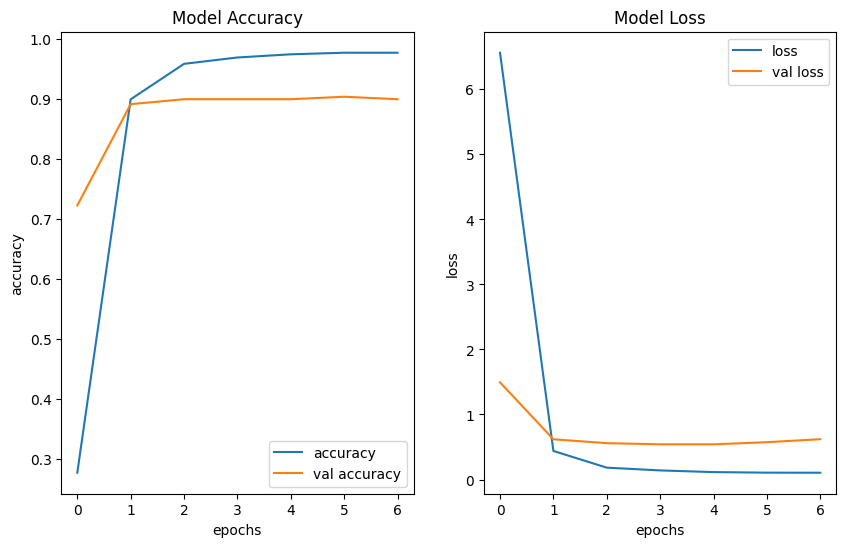

In [70]:
import matplotlib.pyplot as plt
history = model.history
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title("Model Accuracy")
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("Model Loss")
plt.legend()

plt.show()